In [ ]:
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import Sequential

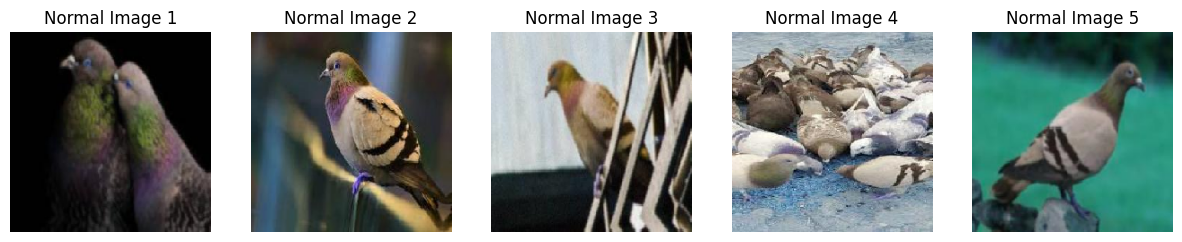

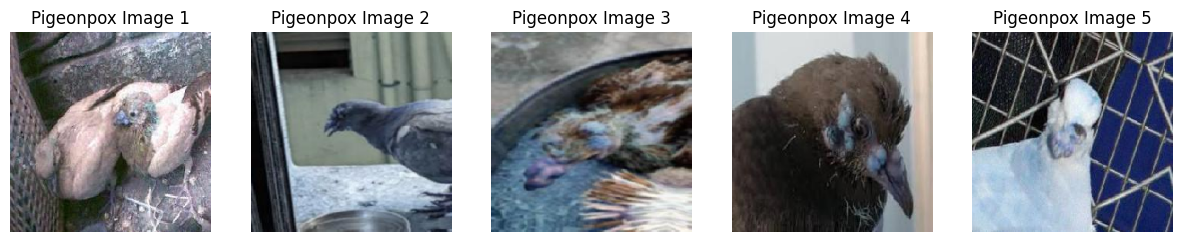

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Paths to your dataset
normal_path = '/content/drive/MyDrive/Pigeon Fox/normal_augmented2'
pigeonpox_path = '/content/drive/MyDrive/Pigeon Fox/pigeonpox_augmented2'

# Function to load and display images
def display_images_in_row(path, label, num_images=5):
    images_to_display = random.sample(os.listdir(path), num_images)

    plt.figure(figsize=(15, 3))
    for i, img_filename in enumerate(images_to_display, 1):
        img_path = os.path.join(path, img_filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)

        plt.subplot(1, num_images, i)
        plt.imshow(img_array.astype('uint8'))
        plt.title(f'{label} Image {i}')
        plt.axis('off')

    plt.show()

# Display 5 images from each class in a row
display_images_in_row(normal_path, 'Normal')
display_images_in_row(pigeonpox_path, 'Pigeonpox')


8/8 [==============================] - 1s 82ms/step


Epoch 1/10
32/32 [==============================] - 1s 17ms/step - loss: 0.8047 - accuracy: 0.6000 - val_loss: 0.5829 - val_accuracy: 0.6996
Epoch 2/10
32/32 [==============================] - 0s 9ms/step - loss: 0.3772 - accuracy: 0.8426 - val_loss: 0.2829 - val_accuracy: 0.9051
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2662 - accuracy: 0.9109 - val_loss: 0.2094 - val_accuracy: 0.9526
Epoch 4/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2102 - accuracy: 0.9356 - val_loss: 0.1716 - val_accuracy: 0.9684
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1778 - accuracy: 0.9475 - val_loss: 0.1484 - val_accuracy: 0.9644
Epoch 6/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1538 - accuracy: 0.9515 - val_loss: 0.1317 - val_accuracy: 0.9723
Epoch 7/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1354 - accuracy: 0.9614 - val_loss: 0.1324 - val_accuracy: 0.9684
Epoch 8/10
32/32 [

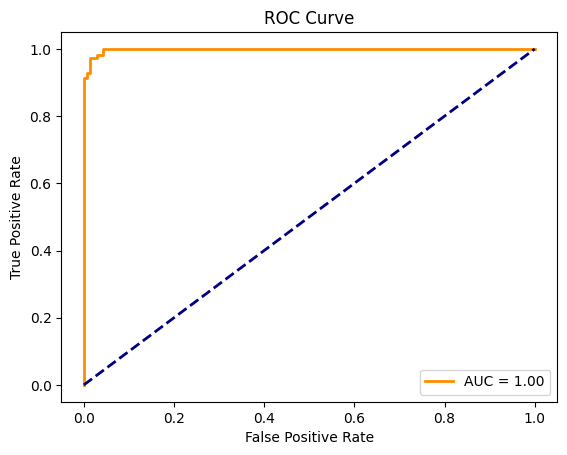

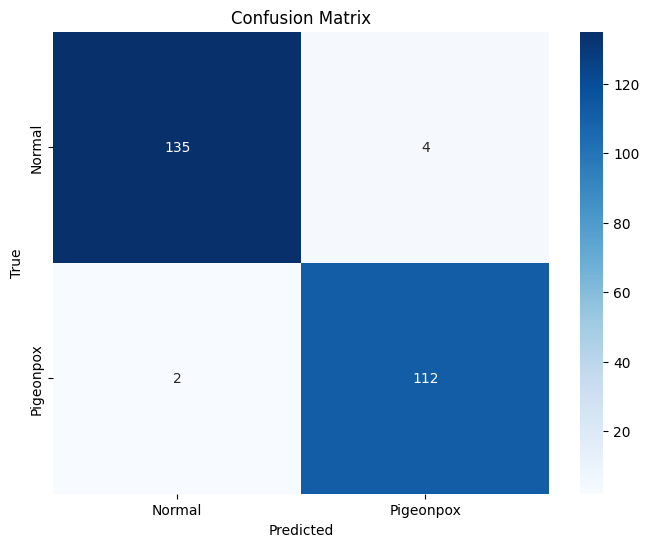

In [ ]:
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Paths to your dataset
normal_path = '/content/drive/MyDrive/Pigeon Fox/normal_augmented2'
pigeonpox_path = '/content/drive/MyDrive/Pigeon Fox/pigeonpox_augmented2'

# Function to load and preprocess images
def load_images(path, label):
    images = []
    labels = []
    for filename in os.listdir(path):
        img_path = os.path.join(path, filename)
        img = image.load_img(img_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess images using DenseNet preprocessing
normal_images, normal_labels = load_images(normal_path, 0)  # label 0 for normal
pigeonpox_images, pigeonpox_labels = load_images(pigeonpox_path, 1)  # label 1 for pigeonpox

# Concatenate the data
X = np.concatenate((normal_images, pigeonpox_images), axis=0)
y = np.concatenate((normal_labels, pigeonpox_labels), axis=0)

# Convert labels to one-hot encoding
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained DenseNet model for feature extraction
densenet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using DenseNet
X_train_features = densenet_base_model.predict(X_train)
X_test_features = densenet_base_model.predict(X_test)

# Define your classification model (DenseNet)
classification_model = Sequential()
classification_model.add(GlobalAveragePooling2D(input_shape=(7, 7, 1024)))  # Global Average Pooling layer to flatten the output from DenseNet
classification_model.add(Dense(2, activation='softmax'))  # Output layer for binary classification (2 classes)

# Compile the model
classification_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = classification_model.fit(X_train_features, y_train, epochs=10, batch_size=32, validation_data=(X_test_features, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Evaluate the model on test data
y_pred = classification_model.predict(X_test_features)
y_pred_binary = np.argmax(y_pred, axis=1)
y_true_binary = np.argmax(y_test, axis=1)

# Calculate metrics
f1 = classification_report(y_true_binary, y_pred_binary, target_names=['Normal', 'Pigeonpox'])
roc_auc = roc_auc_score(y_true_binary, y_pred[:, 1])
acc = accuracy_score(y_true_binary, y_pred_binary)

# Print metrics
print(f"F1 Score:\n{f1}")
print(f"AUC: {roc_auc}")
print(f"Accuracy: {acc}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred[:, 1])
roc_auc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_curve:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pigeonpox'], yticklabels=['Normal', 'Pigeonpox'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
